In [ ]:
%load_ext autoreload
%autoreload 2

# built-in libraries
import os 

# third party libraries
import matplotlib.pyplot as plt 
import numpy as np
import tqdm
import torch 
import torch.nn.functional as func

# repository modules
import models
import train
import adversarial.carlini_wagner as cw
import adversarial.pgd as pgd
import dataset
import utils

REPO_ROOT = os.path.join(os.path.dirname(os.path.realpath('__file__')),"..")
SMAL = os.path.join(REPO_ROOT,"datasets/smal")
PARAMS_FILE = os.path.join(REPO_ROOT, "model_data/smal_data.pt")

traindata = dataset.SmalDataset(SMAL, train=True, test=True)

In [ ]:
model = models.ChebnetClassifier(
    param_conv_layers=[128,128,64,32],
    D_t = traindata.downscale_matrices,
    E_t = traindata.downscaled_edges,
    num_classes = traindata.num_classes,
    parameters_file=PARAMS_FILE)


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

epoch 1 of 2



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]

  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

epoch 2 of 2



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:26<00:00,  1.86it/s]


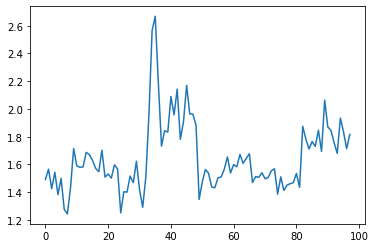


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.53it/s]

tensor(0.3265)


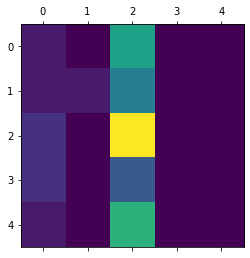

In [28]:
#train network
loss = train.train(
    train_data=traindata,
    classifier=model,
    parameters_file=PARAMS_FILE,
    epoch_number=2,
    learning_rate=1e-4)
plt.plot(loss)
plt.show()

#compute accuracy
accuracy, confusion_matrix = train.evaluate(eval_data=traindata, classifier=model)

print(accuracy)
plt.matshow(confusion_matrix)
plt.show()

In [ ]:
traindata.data.y


In [ ]:
import plotly
import plotly.graph_objects as go
import numpy as np

def visualize(pos, faces, intensity=None):
  cpu = torch.device("cpu")
  if type(pos) != np.ndarray:
    pos = pos.to(cpu).clone().detach().numpy()
  if pos.shape[-1] != 3:
    raise ValueError("Vertices positions must have shape [n,3]")
  if type(faces) != np.ndarray:
    faces = faces.to(cpu).clone().detach().numpy()
  if faces.shape[-1] != 3:
    raise ValueError("Face indices must have shape [m,3]") 
  if intensity is None:
    intensity = np.ones([pos.shape[0]])
  elif type(intensity) != np.ndarray:
    intensity = intensity.to(cpu).clone().detach().numpy()

  x, z, y = pos.T
  i, j, k = faces.T

  mesh = go.Mesh3d(x=x, y=y, z=z,
            color='lightpink',
            intensity=intensity,
            opacity=1,
            colorscale=[[0, 'gold'],[0.5, 'mediumturquoise'],[1, 'magenta']],
            i=i, j=j, k=k,
            showscale=True)
  layout = go.Layout(scene=go.layout.Scene(aspectmode="data")) 

  #pio.renderers.default="plotly_mimetype"
  fig = go.Figure(data=[mesh],
                  layout=layout)
  fig.update_layout(
      autosize=True,
      margin=dict(l=20, r=20, t=20, b=20),
      paper_bgcolor="LightSteelBlue")
  fig.show()
    
def compare(pos1, faces1, pos2, faces2):
    n,m = pos1.shape[0], pos2.shape[0]
    tmpx = torch.cat([pos1, pos2],dim=0)
    tmpf = torch.cat([faces1, faces2+n], dim=0)
    color = torch.zeros([n+m],dtype=pos1.dtype, device=pos1.device)
    color[n:] = (pos1-pos2).norm(p=2,dim=-1)
    visualize(tmpx, tmpf,color)